# Oregon Bicycle-Motor Vehicle Collisions 2009 - 2019
### Data from ODOT

Data was provided as annual MS Access databases. I created a query to extract bicycle-involved crashes with bicyclist information and, in a separate query and file, motorist and vehicle for the same crash numbers. I exported the annual files, two per year, to xlsx format.

### Documentation of queries 
#### Query to produce bicycle_crashes.xlsx

```
SELECT CRASH.*, PARTIC.*, COLLIS_TYP.COLLIS_TYP_LONG_DESC, NON_MOTRST_LOC.NON_MOTRST_LOC_LONG_DESC, ACTN.ACTN_LONG_DESC, ERR.CRASH_ERR_LONG_DESC, CAUSE.CAUSE_LONG_DESC, CAUSE_1.CAUSE_LONG_DESC, EVNT.EVNT_LONG_DESC, MVMNT.MVMNT_LONG_DESC, CAUSE_2.CAUSE_LONG_DESC, CAUSE_3.CAUSE_LONG_DESC

FROM (CAUSE AS CAUSE_3 RIGHT JOIN 
        (CAUSE AS CAUSE_2 RIGHT JOIN 
            (MVMNT INNER JOIN 
                (EVNT RIGHT JOIN 
                    (CAUSE AS CAUSE_1 RIGHT JOIN 
                        (CAUSE RIGHT JOIN 
                            (ERR RIGHT JOIN 
                                (ACTN RIGHT JOIN 
                                ((CRASH INNER JOIN PARTIC ON CRASH.CRASH_ID = PARTIC.CRASH_ID) INNER JOIN NON_MOTRST_LOC 
                                  ON (PARTIC.NON_MOTRST_LOC_CD = NON_MOTRST_LOC.NON_MOTRST_LOC_CD) AND 
                                    (PARTIC.NON_MOTRST_LOC_CD = NON_MOTRST_LOC.NON_MOTRST_LOC_CD)) 
                            ON ACTN.ACTN_CD = PARTIC.ACTN_CD) 
                         ON ERR.CRASH_ERR_CD = PARTIC.PARTIC_ERR_1_CD) 
                    ON CAUSE.CAUSE_CD = PARTIC.PARTIC_CAUSE_1_CD) 
                ON CAUSE_1.CAUSE_CD = PARTIC.PARTIC_CAUSE_2_CD) 
            ON EVNT.EVNT_CD = PARTIC.PARTIC_EVNT_1_CD) 
        ON MVMNT.MVMNT_CD = PARTIC.MVMNT_CD) 
    ON CAUSE_2.CAUSE_CD = CRASH.CRASH_CAUSE_1_CD) 
ON CAUSE_3.CAUSE_CD = CRASH.CRASH_CAUSE_2_CD) 
LEFT JOIN COLLIS_TYP ON CRASH.COLLIS_TYP_CD = COLLIS_TYP.COLLIS_TYP_CD

WHERE (((PARTIC.PARTIC_TYP_CD)="6" Or (PARTIC.PARTIC_TYP_CD)="7"));
```

#### Query to produce bicycle_crashes_motorist.xlsx

```
SELECT VHCL.*, PARTIC.*, ERR.CRASH_ERR_LONG_DESC, CAUSE.CAUSE_LONG_DESC, EVNT.EVNT_LONG_DESC, MVMNT.MVMNT_LONG_DESC, ACTN.ACTN_LONG_DESC

FROM ACTN INNER JOIN ((((CAUSE RIGHT JOIN (MVMNT RIGHT JOIN VHCL ON MVMNT.MVMNT_CD = VHCL.MVMNT_CD) ON CAUSE.CAUSE_CD = VHCL.VHCL_CAUSE_1_CD) INNER JOIN CRASH_KEY_XREF ON VHCL.VHCL_ID = CRASH_KEY_XREF.VHCL_ID) INNER JOIN bicycle_crashes ON CRASH_KEY_XREF.CRASH_ID = bicycle_crashes.CRASH.CRASH_ID) INNER JOIN (EVNT RIGHT JOIN (ERR RIGHT JOIN PARTIC ON ERR.CRASH_ERR_CD = PARTIC.PARTIC_ERR_1_CD) ON EVNT.EVNT_CD = PARTIC.PARTIC_EVNT_1_CD) ON CRASH_KEY_XREF.PARTIC_ID = PARTIC.PARTIC_ID) ON ACTN.ACTN_CD = VHCL.ACTN_CD

WHERE (((PARTIC.PARTIC_TYP_CD)="1"));
```

## Injury Severity Model

#### Import necessary libraries

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#### Read processed data.

In [9]:
crashes = pd.read_excel('../data/bicycle_crashes.xlsx', index=False)
motorists = pd.read_excel('../data/bicycle_crashes_motorist.xlsx', index=False)

### Create a flat analysis file by merging processed data.

In [10]:
crashes.shape

(9180, 210)

In [11]:
motorists.shape

(9239, 97)

There were 9,180 crashes of which 9,092 involved 1 MV, 81 involved 2, and 7 involved 3.
9,008 involved 1 bicyclist. 160 involved 2 bicyclists, and 12 involved 3 bicyclists.

Model uses all bicyclists.

In [23]:
crashes.INJ_SVRTY_SHORT_DESC.value_counts()

INJB    5157
INJC    3122
INJA     580
NONE     234
KILL      86
NO<5       1
Name: INJ_SVRTY_SHORT_DESC, dtype: int64

In [32]:
crashes.CRASH_SPEED_INVLV_FLG.value_counts()

False    9047
True      133
Name: CRASH_SPEED_INVLV_FLG, dtype: int64

In [12]:
# recode
crashes['inj_KA'] = crashes.INJ_SVRTY_CD.apply(lambda x: 1 if x in [1,2] else 0)
crashes['inj_KA'].value_counts()

0    8514
1     666
Name: inj_KA, dtype: int64

In [95]:
# create midblock based on filter for road char ! = "Driveway / Alley" or "Interesection" AND crash not intersection-related
mask = ((crashes.RD_CHAR_CD > 2) & (crashes.ISECT_REL_FLG == False))
crashes['midblock'] = 0
crashes.loc[mask,'midblock'] = 1
 
crashes['midblock'].value_counts()

0    7980
1    1200
Name: midblock, dtype: int64

In [14]:
# create Hit & Run based on Hit & Run collision but not on the part of the bicyclist (who is the 'participant' in this extract)
mask = ((crashes.CRASH_HIT_RUN_FLG == True) & (crashes.PARTIC_HIT_RUN_FLG == False))
crashes['HitRun'] = 0
crashes.loc[mask,'HitRun'] = 1
 
crashes['HitRun'].value_counts()

0    9020
1     160
Name: HitRun, dtype: int64

In [16]:
# drug use is based on a crash involving drugs but bicyclist drug use not reported
mask = ((crashes.DRUG_INVLV_FLG == True) & (crashes.DRUG_USE_RPT_IND == False))
crashes['drug'] = 0
crashes.loc[mask,'drug'] = 1
 
crashes['drug'].value_counts()

0    9164
1      16
Name: drug, dtype: int64

In [17]:
# alcohol use is based on a crash involving drugs but bicyclist alcohol use not reported
mask = ((crashes.ALCHL_INVLV_FLG == True) & (crashes.ALCHL_USE_RPT_IND == False))
crashes['alcohol'] = 0
crashes.loc[mask,'alcohol'] = 1
 
crashes['alcohol'].value_counts()

0    9133
1      47
Name: alcohol, dtype: int64

In [18]:
# recode as 1/0 dummy
crashes['speed'] = crashes.CRASH_SPEED_INVLV_FLG.apply(lambda x: 1 if x == True else 0)
crashes['speed'].value_counts()

0    9047
1     133
Name: speed, dtype: int64

In [19]:
crashes.RD_CNTL_MED_DESC.value_counts(dropna=False)

URBAN CITY STREET       3873
PORTLAND CITY STREET    2650
URBAN HWY SYSTEM        1242
SUBURBAN COUNTY ROAD     423
PORTLAND HWY SYSTEM      340
RURAL HWY SYSTEM         209
SUBURBAN HWY SYSTEM      207
RURAL COUNTY ROAD        175
RURAL CITY STREET         61
Name: RD_CNTL_MED_DESC, dtype: int64

In [20]:
# recode road class
def recode_roadclass(x):
    if  x  in ('URBAN CITY STREET','PORTLAND CITY STREET','RURAL CITY STREET'):
        return 'City Street' 
    elif x in ('URBAN HWY SYSTEM','PORTLAND HWY SYSTEM'):
        return 'Urban Highway'
    elif x in ('RURAL HWY SYSTEM','RURAL COUNTY ROAD'):
        return 'Rural'
    elif x in ('SUBURBAN COUNTY ROAD','SUBURBAN HWY SYSTEM'):
        return 'Suburban'  
crashes['RoadClass'] = crashes.RD_CNTL_MED_DESC.apply(recode_roadclass)
crashes['RoadClass'].value_counts().sort_index()

City Street      6584
Rural             384
Suburban          630
Urban Highway    1582
Name: RoadClass, dtype: int64

In [21]:
# I-HLM = improper helmet use -- do not include in Helmet
crashes.SFTY_EQUIP_USE_SHORT_DESC.value_counts(dropna=False).sort_index()

HELM     1785
I-HLM       9
NONE     2652
UNK      4734
Name: SFTY_EQUIP_USE_SHORT_DESC, dtype: int64

In [22]:
# create separate dummies for Helmet used and Helmet not used (with remaining category of Unknown)
crashes['Helmet'] = crashes.SFTY_EQUIP_USE_SHORT_DESC.apply(lambda x: 1 if x == "HELM" else 0)
crashes['NoHelmet'] = crashes.SFTY_EQUIP_USE_SHORT_DESC.apply(lambda x: 1 if x == "NONE" else 0)
crashes['Helmet'].value_counts()

0    7395
1    1785
Name: Helmet, dtype: int64

In [23]:
# recode age into age groups
def recode_age(x):
    if x == 0:
        return 'Unknown'
    elif  x  <= 9:
        return 'Less than 10' 
    elif x >= 10 and x <=14:
        return '10–14'
    elif x >= 15 and x <=19:
        return '15-19'
    elif x >= 20 and x <=29:
        return '20-29'  
    elif x >= 30 and x <=39:
        return '30–39'
    elif x >= 40 and x <=49:
        return '40-49'
    elif x >= 50 and x <=59:
        return '50–59'
    elif x >= 60 and x <=69:
        return '60-69'    
    elif x >= 70:
        return '70 or more'
crashes['AgeGroup'] = crashes.AGE_VAL.apply(recode_age)

crashes['AgeGroup'].value_counts().sort_index()

10–14            617
15-19            999
20-29           2224
30–39           1438
40-49           1250
50–59           1040
60-69            470
70 or more       183
Less than 10     191
Unknown          768
Name: AgeGroup, dtype: int64

In [24]:
crashes.POST_SPEED_LMT_VAL.value_counts(dropna=False)

nan         4689
35.00000    1386
25.00000    1205
30.00000     533
45.00000     393
40.00000     292
55.00000     250
20.00000     183
0.00000      120
50.00000     100
15.00000       9
65.00000       8
60.00000       7
5.00000        2
10.00000       1
7.00000        1
3.00000        1
Name: POST_SPEED_LMT_VAL, dtype: int64

In [25]:
# recode speed. First replace nulls with 99
crashes.POST_SPEED_LMT_VAL.replace(np.nan,99, inplace=True)
def recode_speed(x):
    if x == 99:
        return 'Unknown'     
    elif  x  >= 50:
        return '50+' 
    elif x in [40,45]:
        return '40-45'
    elif x in [30,35]:
        return '30-35'
    elif x <= 25:
        return '25 or less'
      
crashes['PSL'] = crashes.POST_SPEED_LMT_VAL.apply(recode_speed)

crashes['PSL'].value_counts()

Unknown       4689
30-35         1919
25 or less    1522
40-45          685
50+            365
Name: PSL, dtype: int64

In [26]:
crashes.LGT_COND_SHORT_DESC.value_counts().sort_index()

DARK     312
DAWN     213
DAY     7117
DLIT    1087
DUSK     441
UNK       10
Name: LGT_COND_SHORT_DESC, dtype: int64

In [46]:
# recode lighting condition
def recode_light(x):
    if x == 'DAY':
        return '1 Day'
    elif  x  == 'DARK':
        return 'Dark unlit' 
    elif x == 'DLIT':
        return 'Dark, street lights'
    elif x == 'DUSK':
        return 'Dusk'
    elif x == 'DAWN':
        return 'Dawn'  
    elif x == 'UNK': 
        return 'Unknown'
    
crashes['Lighting'] = crashes.LGT_COND_SHORT_DESC.apply(recode_light)

crashes['Lighting'].value_counts().sort_index()

1 Day                  7117
Dark unlit              312
Dark, street lights    1087
Dawn                    213
Dusk                    441
Unknown                  10
Name: Lighting, dtype: int64

In [28]:
# create 1/0 dummy
crashes['Female'] = crashes.SEX_CD.apply(lambda x: 1 if x == 2 else 0)
crashes['Female'].value_counts()

0    6921
1    2259
Name: Female, dtype: int64

In [29]:
# create 1/0 dummy
crashes['Struck'] = crashes.STRIKG_PARTIC_FLG.apply(lambda x: 0 if x == 1 else 1)
crashes['Struck'].value_counts()

1    6562
0    2618
Name: Struck, dtype: int64

In [33]:
crashes.COLLIS_TYP_LONG_DESC.value_counts()

Turning movement                5513
Angle                           2668
Sideswipe - Overtaking           416
Rear-End                         315
Head-On                           73
Sideswipe - Meeting               56
Parking Maneuver                  53
Backing                           45
Miscellaneous                     29
Fixed Object or Other Object      10
Pedestrian                         1
Non-collision                      1
Name: COLLIS_TYP_LONG_DESC, dtype: int64

In [40]:
# recoode collision type
crashes['COLLISION_TYPE'] = crashes.COLLIS_TYP_LONG_DESC

crashes.COLLISION_TYPE = crashes.COLLISION_TYPE.replace(['Miscellaneous','Fixed Object or Other Object','Non-collision',
                                                              'Pedestrian'],'Other')
crashes.COLLISION_TYPE.value_counts()

Turning movement          5513
Angle                     2668
Sideswipe - Overtaking     416
Rear-End                   315
Head-On                     73
Sideswipe - Meeting         56
Parking Maneuver            53
Backing                     45
Other                       41
Name: COLLISION_TYPE, dtype: int64

In [41]:
# if ANY mv involved in a crash is a large truck, code it as truck-involved, but keep the same number of crash records
motorists['Truck'] = motorists.VHCL_TYP_CD.apply(lambda x: 1 if x in (2,4,5,11) else 0)
Trucks = motorists.groupby(['VHCL_CRASH_ID'])['Truck'].max().reset_index()
crashes = pd.merge(crashes,Trucks,left_on='CRASH_CRASH_ID',right_on='VHCL_CRASH_ID',how='left')

In [42]:
# if ANY mv involved in a crash is a bus, code it as bus-involved, but keep the same number of crash records
motorists['Bus'] = motorists.VHCL_TYP_CD.apply(lambda x: 1 if x in (7,8) else 0)
Buses = motorists.groupby(['VHCL_CRASH_ID'])['Bus'].max().reset_index()
crashes = pd.merge(crashes,Buses,left_on='CRASH_CRASH_ID',right_on='VHCL_CRASH_ID',how='left')

In [43]:
crashes.shape

(9180, 229)

### Save processed and recoded flat file.

In [96]:
crashes.to_csv('../data/crash_processed.csv')

### Run injury severity models.

In [2]:
# open model data file
crashes = pd.read_csv('../data/crash_processed.csv')

C:\Users\pauls\.conda\envs\dsi\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (74,75,82,100,150,165) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Model 1. All observations

In [8]:
# set print output to 5 digits (not scientific)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [17]:
# binomial logit using glm - All Observations
formula = 'inj_KA ~  Truck*midblock + midblock + Struck + Helmet + NoHelmet + HitRun + Bus + Truck + Female + C(AgeGroup) + C(RoadClass) + C(PSL) + C(COLLISION_TYPE) + C(Lighting) + alcohol + drug + speed'
model = smf.glm(formula = formula, data=crashes, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                 9161
Model:                            GLM   Df Residuals:                     9119
Model Family:                Binomial   Df Model:                           41
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2191.6
Date:                Sun, 15 Nov 2020   Deviance:                       4383.1
Time:                        23:44:42   Pearson chi2:                 9.27e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -3.0414      0.210

In [18]:
# print odds ratios and 95% confidence intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
np.exp(conf)

,5%,95%,Odds Ratio
Intercept,0.03162,0.07215,0.04777
C(AgeGroup)[T.15-19],0.51058,1.17408,0.77425
C(AgeGroup)[T.20-29],0.71061,1.45952,1.01840
C(AgeGroup)[T.30–39],0.66816,1.42799,0.97679
C(AgeGroup)[T.40-49],0.67269,1.45334,0.98876
C(AgeGroup)[T.50–59],1.05600,2.23706,1.53699
C(AgeGroup)[T.60-69],1.02133,2.42562,1.57396
C(AgeGroup)[T.70 or more],1.25759,3.60419,2.12899
C(AgeGroup)[T.Less than 10],0.09266,0.74510,0.26275
C(AgeGroup)[T.Unknown],0.20299,0.67054,0.36893


In [19]:
# function to calculate odds ratios from model results and rename variables.
def calc_or():
    # retrieve odds ratios and 95% confidence intervals
    low = np.exp(result.params) - np.exp(result.conf_int()[0])
    high = np.exp(result.conf_int()[1]) - np.exp(result.params)
    all_coef_df = pd.DataFrame({'coef': np.exp(result.params.values[1:]),
#                             'err': err_series.values[1:],
                            'low_err': low.values[1:],
                            'high_err': high.values[1:],
                            'varname': low.index.values[1:]})
    # make nicer looking variable names
    all_coef_df.varname.replace(
    ['C(AgeGroup)[T.15-19]',
     'C(AgeGroup)[T.20-29]',
     'C(AgeGroup)[T.30–39]',
     'C(AgeGroup)[T.40-49]',
     'C(AgeGroup)[T.50–59]',
     'C(AgeGroup)[T.60-69]',
     'C(AgeGroup)[T.70 or more]',
     'C(AgeGroup)[T.Unknown]',
     'C(AgeGroup)[T.Less than 10]',
     'C(RoadClass)[T.Rural]',
     'C(RoadClass)[T.Suburban]',
     'C(RoadClass)[T.Urban Highway]',
     'C(PSL)[T.30-35]',
     'C(PSL)[T.40-45]',
     'C(PSL)[T.50+]',
     'C(PSL)[T.Unknown]',
     'C(COLLISION_TYPE)[T.Backing]',
     'C(COLLISION_TYPE)[T.Head-On]',
     'C(COLLISION_TYPE)[T.Parking Maneuver]',
     'C(COLLISION_TYPE)[T.Turning movement]',
     'C(COLLISION_TYPE)[T.Other]',
     'C(COLLISION_TYPE)[T.Rear-End]',
     'C(COLLISION_TYPE)[T.Sideswipe - Meeting]',
     'C(COLLISION_TYPE)[T.Sideswipe - Overtaking]',
     'C(Lighting)[T.Dark, street lights]',
     'C(Lighting)[T.Dark unlit]',
     'C(Lighting)[T.Dawn]',
     'C(Lighting)[T.Dusk]',
     'C(Lighting)[T.Unknown]',
     'alcohol',
     'drug',
     'speed',
     'midblock',
     'Struck',
     'Helmet',
     'NoHelmet',
     'HitRun',
     'Bus',
     'Truck',
     'Female'
     ],
     ['15-19',
     '20-29',
     '30–39',
     '40-49',
     '50–59',
     '60-69',
     '70 or more',
     'Age unknown',
     'Less than 10',
     'Rural (ref: city st)',
     'Suburban (ref: city st)',
     'Urban hwy (ref: city st)',
     '30-35 mph (ref: <=25 mph)',
     '40-45 mph (ref: <=25 mph)',
     '50+ mph (ref: <=25 mph)',
     'Unk. PSL (ref: <=25 mph)',
     'Backing (ref: Angle)',
     'Head-on (ref: Angle)',
     'Parking (ref: Angle)',
     'Turning (ref: Angle)',
     'Other (ref: Angle)',
     'Rear-end (ref: Angle)',
     'Sideswipe - opp. dir. (ref: Angle)',
     'Sideswipe - same dir. (ref: Angle)',
     'Dark, streetlights (ref: Daylight)',
     'Dark unlit (ref: Daylight)',
     'Dawn (ref: Daylight)',
     'Dusk (ref: Daylight)',
     'Unk. lighting (ref: Daylight)',
     'Alcohol-related (ref: not or unk.)',
     'Drugged driver (ref: not or unk.)',
     'Speeding related (ref: not or unk.)',
     'Midblock (ref: intersection)',
     'Bicyclist struck (ref: striking)',
     'Helmet used (ref: unk.)',
     'Helmet NOT used (ref: unk.)',
     'Hit and run (ref: not)',
     'Bus',
     'Large truck',
     'Female'
      ], inplace=True)
    return all_coef_df                           

In [20]:
# function to plot coeffiecients and confidence intervals
def plot_coefs(df,ylabel,xlabel):
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize=(20, 15))    
    df.plot(y='coef', 
                 x='varname', 
                 kind='barh', 
                 ax=ax, color='none',                   
                 logx = True,
                 xerr=[df.low_err, df.high_err],
                 capsize=8,
                 legend = False)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xlabel(xlabel,fontsize=20)
    ax.scatter(y=pd.np.arange(df.shape[0]), 
               marker='s', s=120, 
               x=df['coef'], color='orange')
    ax.axvline(x=1, linestyle='--', color='r', linewidth=3)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=10))
    ax.xaxis.set_minor_locator(ticker.LogLocator(base=10,subs=(0.2,0.4,0.6,0.8)))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.set_xlim(left=.09)

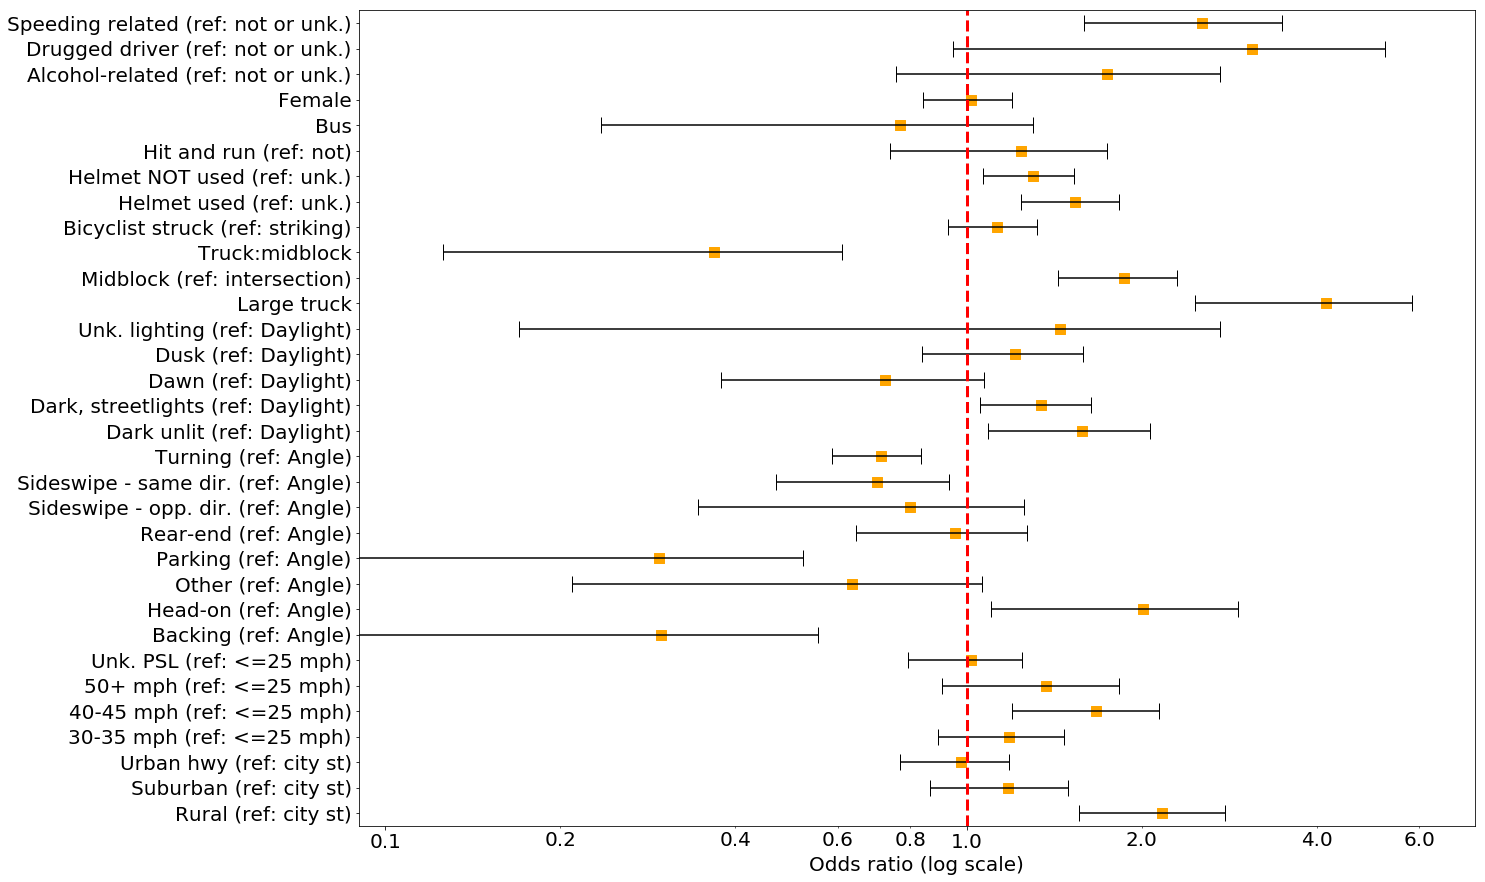

In [21]:
# Plot coefficients and CI on log scale
all_coef_df = calc_or()
coef_df = all_coef_df[9:].copy()
ylabel=''
xlabel='Odds ratio (log scale)'
plot_coefs(coef_df,ylabel,xlabel)
plt.savefig('../images/ORs_all.png', bbox_inches="tight")

#### Model 2. Without urban / rural / suburban

In [15]:
# binomial logit using glm - All Observations
formula = 'inj_KA ~ Truck*midblock + midblock + Struck + Helmet + NoHelmet + HitRun + Bus + Truck + Female + C(AgeGroup) + C(PSL) + C(COLLISION_TYPE) + C(Lighting) + alcohol + drug + speed'
model = smf.glm(formula = formula, data=crashes, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                 9161
Model:                            GLM   Df Residuals:                     9121
Model Family:                Binomial   Df Model:                           39
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2201.8
Date:                Sun, 15 Nov 2020   Deviance:                       4403.7
Time:                        23:43:55   Pearson chi2:                 9.26e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -3.0272      0.209

In [16]:
# print odds ratios and 95% confidence intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
np.exp(conf)

,5%,95%,Odds Ratio
Intercept,0.03216,0.07299,0.04845
C(AgeGroup)[T.15-19],0.49694,1.13979,0.75260
C(AgeGroup)[T.20-29],0.67872,1.38885,0.97090
C(AgeGroup)[T.30–39],0.63877,1.36080,0.93233
C(AgeGroup)[T.40-49],0.65521,1.41125,0.96160
C(AgeGroup)[T.50–59],1.03449,2.18456,1.50330
C(AgeGroup)[T.60-69],1.01026,2.38928,1.55364
C(AgeGroup)[T.70 or more],1.22403,3.49694,2.06890
C(AgeGroup)[T.Less than 10],0.09174,0.73605,0.25986
C(AgeGroup)[T.Unknown],0.19286,0.63580,0.35017


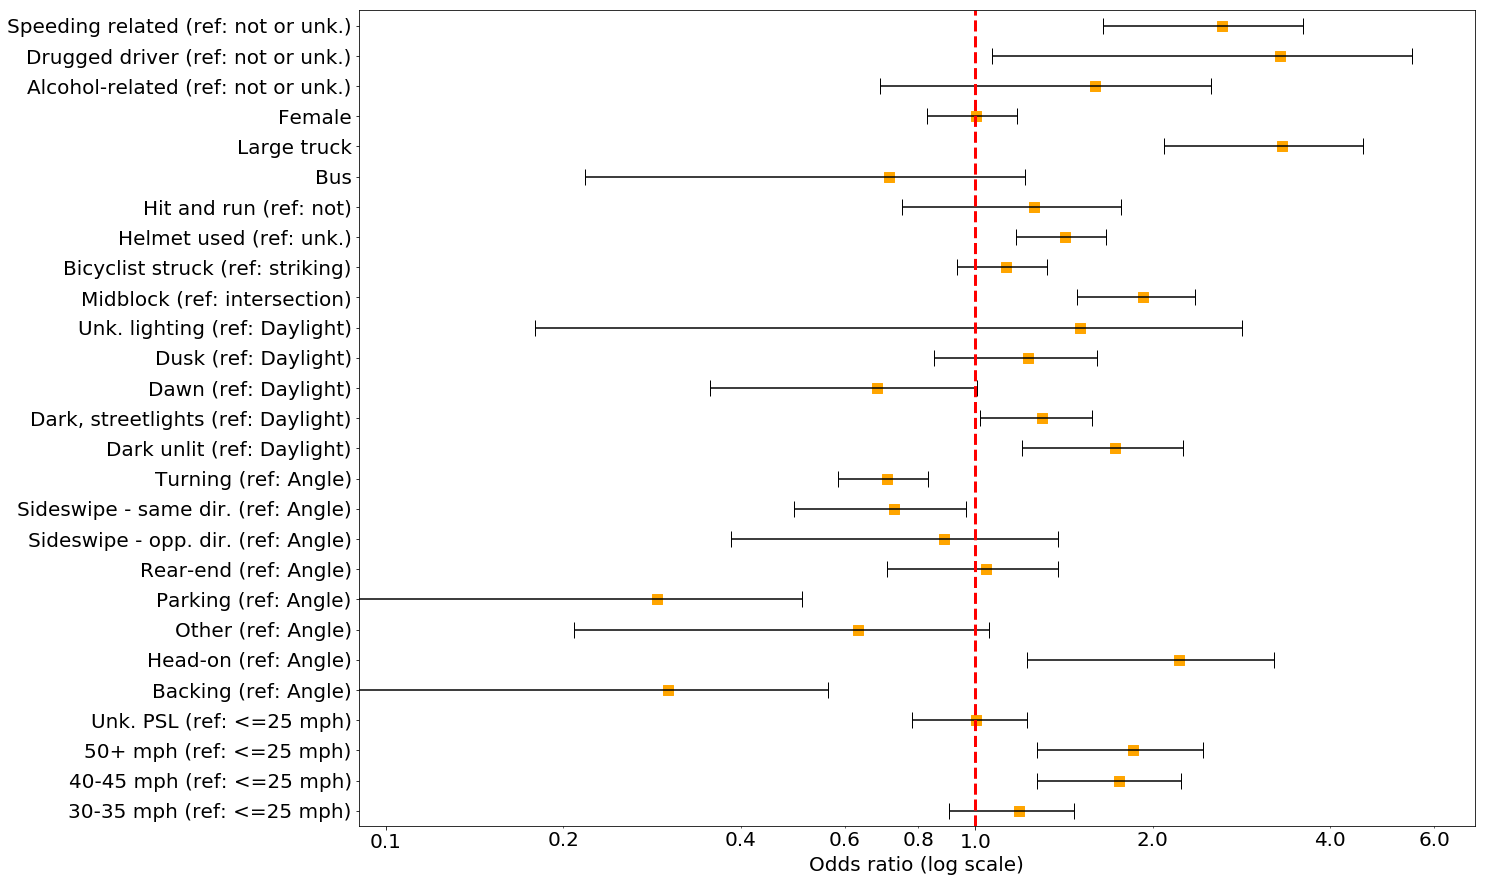

In [13]:
# Plot coefficients and CI on log scale
all_coef_df = calc_or()
coef_df = all_coef_df[9:].copy()
ylabel=''
xlabel='Odds ratio (log scale)'
plot_coefs(coef_df,ylabel,xlabel)
plt.savefig('../images/ORs_PSL.png', bbox_inches="tight")

#### Model 3.  Urban areas only.

In [9]:
# binomial logit using glm - excluding Rural areas
formula = 'inj_KA ~  midblock + Struck + Helmet + HitRun + Bus + Truck + Female + C(AgeGroup) + C(PSL) + C(COLLISION_TYPE) + C(Lighting) + alcohol + drug + speed'
model = smf.glm(formula = formula, data=crashes[(crashes.RoadClass != 'Rural')], family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                 8777
Model:                            GLM   Df Residuals:                     8740
Model Family:                Binomial   Df Model:                           36
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2020.3
Date:                Fri, 13 Nov 2020   Deviance:                       4040.6
Time:                        19:45:44   Pearson chi2:                 8.77e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -2.7980      0.207

In [10]:
# print odds ratios and 95% confidence intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
np.exp(conf)

,5%,95%,Odds Ratio
Intercept,0.04058,0.09148,0.06093
C(AgeGroup)[T.15-19],0.46302,1.11149,0.71739
C(AgeGroup)[T.20-29],0.65482,1.38602,0.95268
C(AgeGroup)[T.30–39],0.63869,1.40984,0.94892
C(AgeGroup)[T.40-49],0.60909,1.37377,0.91474
C(AgeGroup)[T.50–59],0.97102,2.14247,1.44235
C(AgeGroup)[T.60-69],0.99838,2.49071,1.57692
C(AgeGroup)[T.70 or more],1.29328,3.86691,2.23630
C(AgeGroup)[T.Less than 10],0.10288,0.83409,0.29294
C(AgeGroup)[T.Unknown],0.17148,0.58544,0.31685


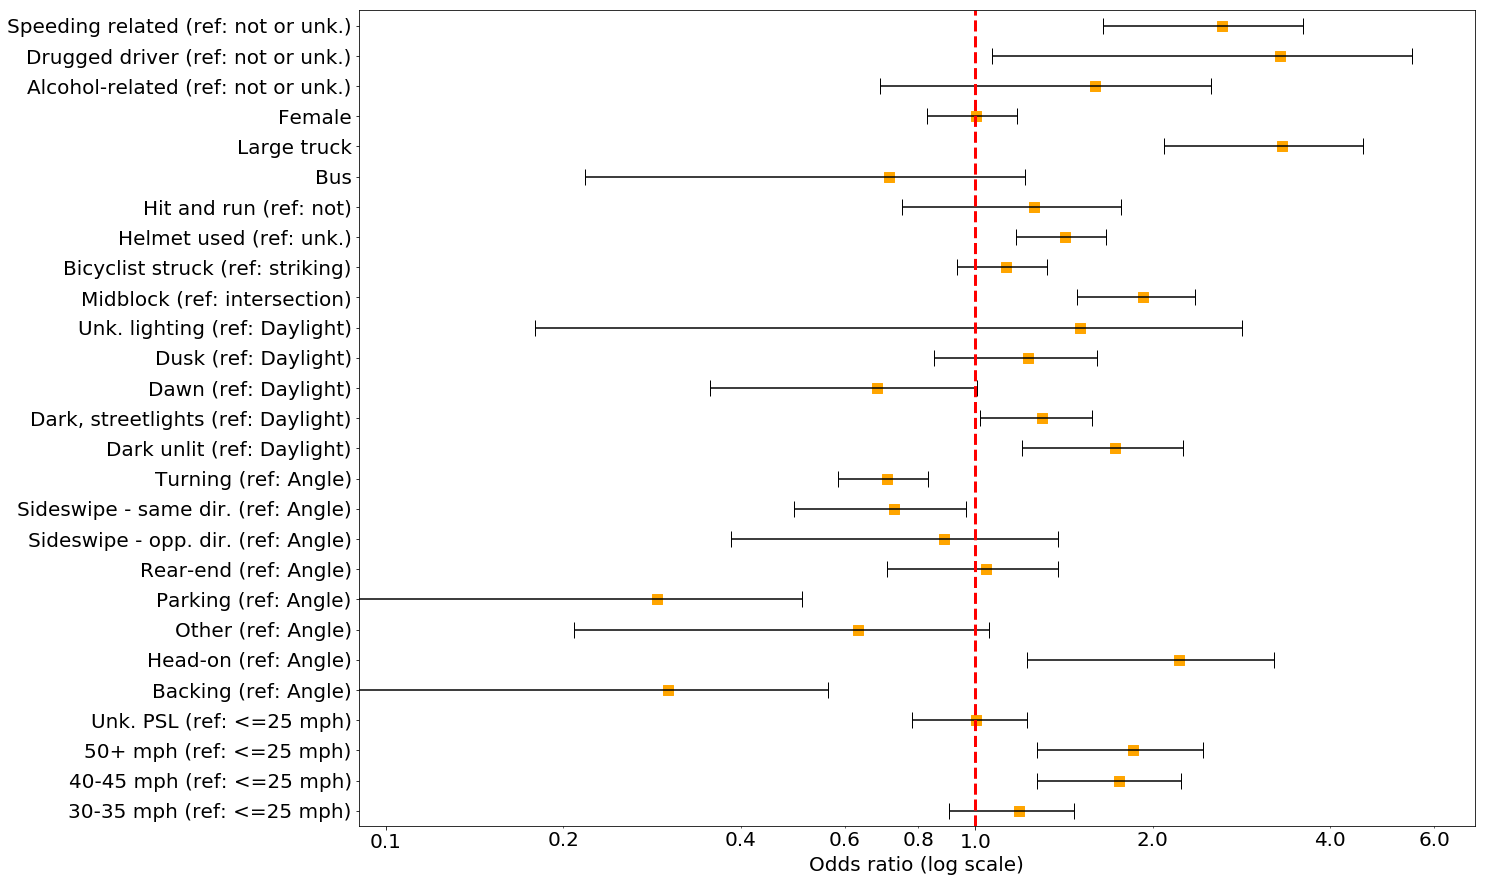

In [14]:
# Plot coefficients and CI on log scale
all_coef_df = calc_or()
coef_df = all_coef_df[9:].copy()
ylabel=''
xlabel='Odds ratio (log scale)'
plot_coefs(coef_df,ylabel,xlabel)
plt.savefig('../images/ORs_urban.png', bbox_inches="tight")

#### Model 4: NTSB variables only, all observations

In [16]:
# binomial logit using glm - All Observations
formula = 'inj_KA ~  midblock + C(RoadClass) + C(PSL)'
model = smf.glm(formula = formula, data=crashes, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 inj_KA   No. Observations:                 9180
Model:                            GLM   Df Residuals:                     9171
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2296.7
Date:                Fri, 13 Nov 2020   Deviance:                       4593.3
Time:                        19:50:23   Pearson chi2:                 9.23e+03
No. Iterations:                     6   Covariance Type:             nonrobust
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -2.8486      0.110    -25.965      0.000      -3.064      -2

In [17]:
# print odds ratios and 95% confidence intervals
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

                                   5%     95%  Odds Ratio
Intercept                     0.04672 0.07182     0.05792
C(RoadClass)[T.Rural]         1.80795 3.34498     2.45918
C(RoadClass)[T.Suburban]      0.87073 1.59279     1.17766
C(RoadClass)[T.Urban Highway] 0.75434 1.20829     0.95471
C(PSL)[T.30-35]               0.93840 1.62217     1.23379
C(PSL)[T.40-45]               1.29188 2.46907     1.78598
C(PSL)[T.50+]                 1.06400 2.30492     1.56602
C(PSL)[T.Unknown]             0.72352 1.17280     0.92117
midblock                      1.76942 2.61509     2.15109


In [3]:
crashes.columns.tolist()

['Unnamed: 0',
 'ACTN_CD',
 'ACTN_LONG_DESC',
 'ACTN_SHORT_DESC',
 'AGE_VAL',
 'AGY_ST_NO',
 'AIRBAG_DEPLOY_IND',
 'ALCHL_INVLV_FLG',
 'ALCHL_USE_RPT_IND',
 'BAC_VAL',
 'CAUSE_1_CAUSE_LONG_DESC',
 'CAUSE_2_CAUSE_LONG_DESC',
 'CAUSE_3_CAUSE_LONG_DESC',
 'CAUSE_CAUSE_LONG_DESC',
 'CITY_SECT_ID',
 'CITY_SECT_NM',
 'CMPSS_DIR_CD',
 'CMPSS_DIR_FROM_CD',
 'CMPSS_DIR_TO_CD',
 'CNTY_ID',
 'CNTY_NM',
 'COLLIS_TYP_CD',
 'COLLIS_TYP_LONG_DESC',
 'COLLIS_TYP_SHORT_DESC',
 'CRASH_CAUSE_1_CD',
 'CRASH_CAUSE_1_SHORT_DESC',
 'CRASH_CAUSE_2_CD',
 'CRASH_CAUSE_2_SHORT_DESC',
 'CRASH_CAUSE_3_CD',
 'CRASH_CAUSE_3_SHORT_DESC',
 'CRASH_CRASH_ID',
 'CRASH_DAY_NO',
 'CRASH_DT',
 'CRASH_ERR_LONG_DESC',
 'CRASH_EVNT_1_CD',
 'CRASH_EVNT_1_SHORT_DESC',
 'CRASH_EVNT_2_CD',
 'CRASH_EVNT_2_SHORT_DESC',
 'CRASH_EVNT_3_CD',
 'CRASH_EVNT_3_SHORT_DESC',
 'CRASH_HIT_RUN_FLG',
 'CRASH_HR_NO',
 'CRASH_HR_SHORT_DESC',
 'CRASH_LAST_UD_DT',
 'CRASH_MO_NO',
 'CRASH_SPEED_INVLV_FLG',
 'CRASH_SVRTY_CD',
 'CRASH_SVRTY_SHORT_DESC'

In [4]:
crashes.PARTIC_CAUSE_1_SHORT_DESC.value_counts()

NO CODE     4769
IN RDWY     1101
NO-YIELD     973
PAS-STOP     344
NT VISBL     327
OTHER        279
DIS SIG      277
DIS--RAG     267
TOO-FAST     176
LEFT-CTR     107
WRNG WAY     105
IMP-TURN      94
INATTENT      69
IMP LN C      66
IMP-OVER      65
TOO-CLOS      58
DIS TCD       27
F AVOID       20
CARELESS      18
NM INATT      10
RECKLESS       9
VIEW OBS       5
USED MDN       5
OTHR-IMP       3
ILLNESS        3
FATIGUE        2
PHANTOM        1
Name: PARTIC_CAUSE_1_SHORT_DESC, dtype: int64

In [5]:
crashes.CRASH_CAUSE_1_SHORT_DESC.value_counts()

NO-YIELD    5318
IN RDWY      915
PAS-STOP     420
DIS SIG      354
DIS--RAG     346
IMP-TURN     184
OTHER        174
TOO-FAST     165
INATTENT     153
OTHR-IMP     136
CARELESS     133
IMP-OVER     122
NT VISBL     117
LEFT-CTR     103
TOO-CLOS     102
WRNG WAY      90
IMP LN C      82
RECKLESS      62
VIEW OBS      38
F AVOID       36
DIS TCD       36
NO CODE       27
SPEED         14
NM INATT      12
ILLNESS        9
FATIGUE        9
DEF BRKE       8
PHANTOM        6
USED MDN       4
DEF STER       2
RD RAGE        1
LOADSHFT       1
MECH-DEF       1
Name: CRASH_CAUSE_1_SHORT_DESC, dtype: int64